In [20]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path

import tensorflow as tf
import numpy as np
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [21]:
import pathlib
data_dir_train = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [23]:
# went with batch size of 32 bc it's a good balance between speed and memory usage.
batch_size = 32
img_height = 180
img_width = 180

random.seed(123)
tf.random.set_seed(123)
np.random.seed(123)


In [24]:
# preparing the training set.
# added validation split for cross-validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # made 20% of training data set for validation
    subset="training",     
    seed=rnd_seed,        
    image_size=(img_height, img_width),  
    batch_size=batch_size 
)

# same as above but for the val subset of the training data.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=rnd_seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Found 118 files belonging to 9 classes.


In [25]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


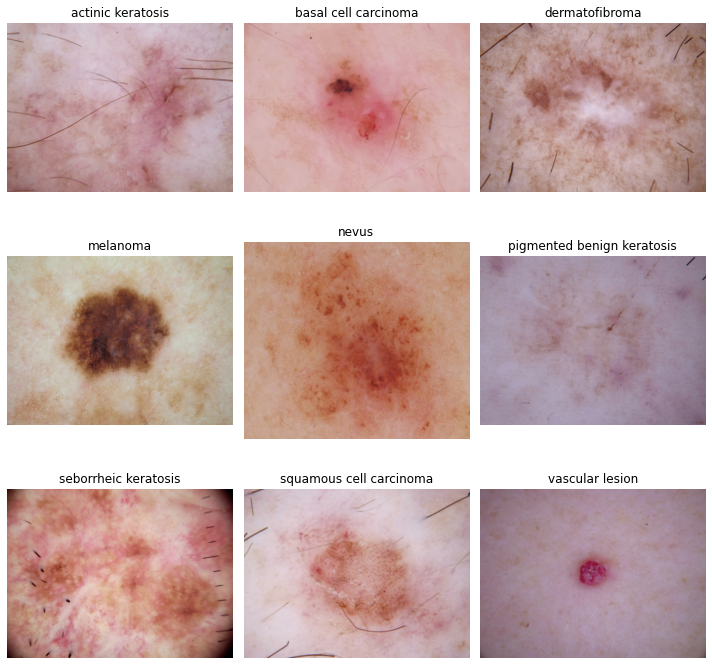

In [26]:

# just wanna make sure my classes are as expected.
num_classes = len(class_names)  
plt.figure(figsize=(10,10))  
for i in range(num_classes):
    plt.subplot(3,3,i+1) 
    class_dir = data_dir_train / class_names[i]  # grabbing a random image from each class directory
    image_path = list(class_dir.glob('*.jpg'))[0]  
    image = img.imread(str(image_path))
    plt.title(class_names[i])  
    plt.imshow(image)  
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [27]:
for image_batch, labels_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [28]:
AUTOTUNE = tf.data.AUTOTUNE  # letting tf figure out the best settings
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # shuffle training data for better learning
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  # validation doesn't need shuffling
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  


In [29]:
# stacked Conv2D and MaxPooling layers to extract spatial features from images.
model = Sequential([
    # resxale layer to normalize pixel values
    layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    
    # first convolutional block: 32 filters, relu activation.
    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPool2D(),  # downsampling layer
    
    # second block: more filters for deeper feature extraction.
    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPool2D(),

    #keep adding filters
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPool2D(),
    
    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPool2D(),
    
    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPool2D(),
    
    # flattening the output for the fully connected layers.
    Flatten(),
    Dense(1024, activation="relu"),  
    Dense(units=num_classes, activation='softmax')  # O
])


In [30]:
opt = Adam(learning_rate=0.001)  # using Adam bc its fast and works well for most problems.

model.compile(
    optimizer=opt,
    loss=SparseCategoricalCrossentropy(from_logits=False),  
    metrics=['accuracy'] 
)

model.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 128)      

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # stop if no improvement
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)  

# computing class weights to handle class imbalance.
labels = np.concatenate([y for x, y in train_ds], axis=0)  
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights_values))  
print("Class Weights:", class_weights)


Class Weights: {0: 2.1642512077294684, 1: 0.6443725278676735, 2: 2.585858585858586, 3: 0.5656565656565656, 4: 0.7188126754913758, 5: 0.5381381381381382, 6: 3.4329501915708813, 7: 1.402190923317684, 8: 1.731400966183575}


In [32]:
epochs = 25  # training for up to 25 epochs (stops earlier if val_loss doesn't improve)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint, reduce_lr],  # using all callbacks
    class_weight=class_weights  # balancing the classes
)

Epoch 1/25
56/56 [==============================] - 5s 74ms/step - loss: 2.2183 - accuracy: 0.1032 - val_loss: 2.1971 - val_accuracy: 0.0403
Epoch 2/25
56/56 [==============================] - 3s 45ms/step - loss: 2.2009 - accuracy: 0.1032 - val_loss: 2.1875 - val_accuracy: 0.1790
Epoch 3/25
56/56 [==============================] - 3s 45ms/step - loss: 2.1377 - accuracy: 0.1713 - val_loss: 1.9271 - val_accuracy: 0.2349
Epoch 4/25
56/56 [==============================] - 3s 46ms/step - loss: 1.9008 - accuracy: 0.2573 - val_loss: 2.3722 - val_accuracy: 0.1521
Epoch 5/25
56/56 [==============================] - 3s 45ms/step - loss: 1.7264 - accuracy: 0.3320 - val_loss: 1.7250 - val_accuracy: 0.2573
Epoch 6/25
56/56 [==============================] - 3s 46ms/step - loss: 1.6396 - accuracy: 0.3069 - val_loss: 1.6824 - val_accuracy: 0.3691
Epoch 7/25
56/56 [==============================] - 3s 46ms/step - loss: 1.5728 - accuracy: 0.3454 - val_loss: 1.5905 - val_accuracy: 0.4474
Epoch 8/25
56

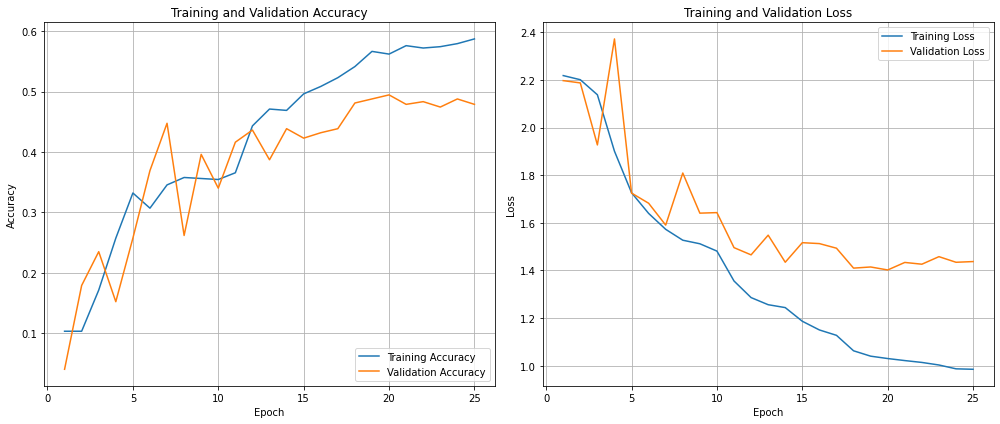

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Plotting accuracy.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plotting loss.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

4/4 [==============================] - 3s 18ms/step - loss: 2.2452 - accuracy: 0.4237
Test Accuracy: 0.4237
Test Loss: 2.2452


In [35]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = np.argmax(model.predict(test_ds), axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.57      0.50      0.53        16
      basal cell carcinoma       0.36      0.25      0.30        16
            dermatofibroma       0.18      0.12      0.15        16
                  melanoma       0.30      0.19      0.23        16
                     nevus       0.50      0.81      0.62        16
pigmented benign keratosis       0.43      0.75      0.55        16
      seborrheic keratosis       0.40      0.67      0.50         3
   squamous cell carcinoma       0.40      0.25      0.31        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.42       118
                 macro avg       0.42      0.47      0.43       118
              weighted avg       0.40      0.42      0.39       118



In [ ]:
# model not great thus far, more work to to in future w data augmentation and better handling of imbalance